
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.20?urlpath=lab/tree/tutorials/starting/analysis_1.ipynb)
- You may download all the notebooks as a [tar file](../../_downloads/notebooks-0.20.tar).
- **Source files:**
[analysis_1.ipynb](../../_static/notebooks/analysis_1.ipynb) |
[analysis_1.py](../../_static/notebooks/analysis_1.py)
</div>


# High level interface

## Prerequisites

- Understanding the gammapy data workflow, in particular what are DL3 events and instrument response functions (IRF).

## Context

This notebook is an introduction to gammapy analysis using the high level interface. 

Gammapy analysis consists in two main steps. 

The first one is data reduction: user selected observations  are reduced to a geometry defined by the user. 
It can be 1D (spectrum from a given extraction region) or 3D (with a sky projection and an energy axis). 
The resulting reduced data and instrument response functions (IRF) are called datasets in Gammapy.

The second step consists in setting a physical model on the datasets and fitting it to obtain relevant physical information.


**Objective: Create a 3D dataset of the Crab using the H.E.S.S. DL3 data release 1 and perform a simple model fitting of the Crab nebula.**

## Proposed approach

This notebook uses the high level `Analysis` class to orchestrate data reduction. In its current state, `Analysis` supports the standard analysis cases of joint or stacked 3D and 1D analyses. It is instantiated with an `AnalysisConfig` object that gives access to analysis parameters either directly or via a YAML config file. 

To see what is happening under-the-hood and to get an idea of the internal API, a second notebook performs the same analysis without using the `Analysis` class. 

In summary, we have to:

- Create an `~gammapy.analysis.AnalysisConfig` object and edit it to define the analysis configuration:
    - Define what observations to use
    - Define the geometry of the dataset (data and IRFs)
    - Define the model we want to fit on the dataset.
- Instantiate a `~gammapy.analysis.Analysis` from this configuration and run the different analysis steps
    - Observation selection
    - Data reduction
    - Model fitting
    - Estimating flux points

Finally we will compare the results against a reference model.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from astropy import units as u
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import create_crab_spectral_model

## Analysis configuration

For configuration of the analysis we use the [YAML](https://en.wikipedia.org/wiki/YAML) data format. YAML is a machine readable serialisation format, that is also friendly for humans to read. In this tutorial we will write the configuration file just using Python strings, but of course the file can be created and modified with any text editor of your choice.

Here is what the configuration for our analysis looks like:

In [3]:
config = AnalysisConfig()
# the AnalysisConfig gives access to the various parameters used from logging to reduced dataset geometries
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 1.0 TeV, max: 10.0 TeV, nbins: 5}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
        map_selection: [counts, exposure, background, psf, ed

### Setting the data to use

We want to use Crab runs from the H.E.S.S. DL3-DR1. We define here the datastore and a cone search of observations pointing with 5 degrees of the Crab nebula. Parameters can be set directly or as a python dict.

PS: do not forget to setup your environment variable _$GAMMAPY\_DATA_ to your local directory containing the H.E.S.S. DL3-DR1 as described in [getting started](https://docs.gammapy.org/dev/getting-started/index.html#download-tutorials).

In [4]:
# We define the datastore containing the data
config.observations.datastore = "$GAMMAPY_DATA/hess-dl3-dr1"

# We define the cone search parameters
config.observations.obs_cone.frame = "icrs"
config.observations.obs_cone.lon = "83.633 deg"
config.observations.obs_cone.lat = "22.014 deg"
config.observations.obs_cone.radius = "5 deg"

# Equivalently we could have set parameters with a python dict
# config.observations.obs_cone = {"frame": "icrs", "lon": "83.633 deg", "lat": "22.014 deg", "radius": "5 deg"}

### Setting the reduced datasets geometry

In [5]:
# We want to perform a 3D analysis
config.datasets.type = "3d"
# We want to stack the data into a single reduced dataset
config.datasets.stack = True

# We fix the WCS geometry of the datasets
config.datasets.geom.wcs.skydir = {
    "lon": "83.633 deg",
    "lat": "22.014 deg",
    "frame": "icrs",
}
config.datasets.geom.wcs.width = {"width": "2 deg", "height": "2 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# We now fix the energy axis for the counts map
config.datasets.geom.axes.energy.min = "1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc)
config.datasets.geom.axes.energy_true.min = "0.5 TeV"
config.datasets.geom.axes.energy_true.max = "20 TeV"
config.datasets.geom.axes.energy_true.nbins = 20

### Setting the background normalization maker

In [6]:
config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}

### Setting the exclusion mask

In order to properly adjust the background normalisation on regions without gamma-ray signal, one needs to define an exclusion mask for the background normalisation.
For this tutorial, we use the following one ``$GAMMAPY_DATA/joint-crab/exclusion/exclusion_mask_crab.fits.gz``

In [7]:
config.datasets.background.exclusion = (
    "$GAMMAPY_DATA/joint-crab/exclusion/exclusion_mask_crab.fits.gz"
)

### Setting modeling and fitting parameters
`Analysis` can perform a few modeling and fitting tasks besides data reduction. Parameters have then to be passed to the configuration object.

Here we define the energy range on which to perform the fit. We also set the energy edges used for flux point computation as well as the correlation radius to compute excess and significance maps. 

In [8]:
config.fit.fit_range.min = 1 * u.TeV
config.fit.fit_range.max = 10 * u.TeV
config.flux_points.energy = {"min": "1 TeV", "max": "10 TeV", "nbins": 4}
config.excess_map.correlation_radius = 0.1 * u.deg

We're all set. 
But before we go on let's see how to save or import `AnalysisConfig` objects though YAML files.

### Using YAML configuration files

One can export/import the `AnalysisConfig` to/from a YAML file.

In [9]:
config.write("config.yaml", overwrite=True)

In [10]:
config = AnalysisConfig.read("config.yaml")
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg, radius: 5.0 deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: icrs, lon: 83.633 deg, lat: 22.014 deg}
                binsize: 0.02 deg
                width: {width: 2.0 deg, height: 2.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 1.0 TeV, max: 10.0 TeV, nbins: 10}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 20}
        map_selection: [counts, e

## Running the analysis

We first create an `~gammapy.analysis.Analysis` object from our configuration.

In [11]:
analysis = Analysis(config)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


###  Observation selection

We can directly select and load the observations from disk using `~gammapy.analysis.Analysis.get_observations()`:

In [12]:
analysis.get_observations()

Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4


The observations are now available on the `Analysis` object. The selection corresponds to the following ids:

In [13]:
analysis.observations.ids

['23523', '23526', '23559', '23592']

To see how to explore observations, please refer to the following notebook: [CTA with Gammapy](../data/cta.ipynb) or  [HESS with Gammapy](../data/hess.ipynb) 

## Data reduction

Now we proceed to the data reduction. In the config file we have chosen a WCS map geometry, energy axis and decided to stack the maps. We can run the reduction using `.get_datasets()`:

In [14]:
%%time
analysis.get_datasets()

Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 23523
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23526
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23559
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 23592
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker


CPU times: user 3.22 s, sys: 323 ms, total: 3.54 s
Wall time: 4.48 s


As we have chosen to stack the data, there is finally one dataset contained which we can print:

In [15]:
print(analysis.datasets["stacked"])

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 2485 
  Total background counts         : 1997.49
  Total excess counts             : 487.51

  Predicted counts                : 1997.49
  Predicted background counts     : 1997.49
  Predicted excess counts         : nan

  Exposure min                    : 2.73e+08 m2 s
  Exposure max                    : 3.52e+09 m2 s

  Number of total bins            : 100000 
  Number of fit bins              : 100000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




As you can see the dataset comes with a predefined background model out of the data reduction, but no source model has been set yet.

The counts, exposure and background model maps are directly available on the dataset and can be printed and plotted:

In [16]:
counts = analysis.datasets["stacked"].counts
counts.smooth("0.05 deg").plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

We can also compute the map of the sqrt_ts (significance) of the excess counts above the background. The correlation radius to sum counts is defined in the config file.

Computing excess maps.


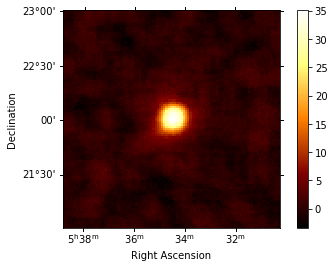

In [17]:
analysis.get_excess_map()
analysis.excess_map["sqrt_ts"].plot(add_cbar=True);

## Save dataset to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of maps, PSF and energy dispersion is slow if you have a lot of data. We first create a folder:

In [18]:
path = Path("analysis_1")
path.mkdir(exist_ok=True)

And then write the maps and IRFs to disk by calling the dedicated `write()` method:

In [19]:
filename = path / "crab-stacked-dataset.fits.gz"
analysis.datasets[0].write(filename, overwrite=True)

## Model fitting

Now we define a model to be fitted to the dataset. Here we use its YAML definition to load it:

In [20]:
model_config = """
components:
- name: crab
  type: SkyModel
  spatial:
    type: PointSpatialModel
    frame: icrs
    parameters:
    - name: lon_0
      value: 83.63
      unit: deg
    - name: lat_0 
      value: 22.014    
      unit: deg
  spectral:
    type: PowerLawSpectralModel
    parameters:
    - name: amplitude      
      value: 1.0e-12
      unit: cm-2 s-1 TeV-1
    - name: index
      value: 2.0
      unit: ''
    - name: reference
      value: 1.0
      unit: TeV
      frozen: true
"""

Now we set the model on the analysis object:

In [21]:
analysis.set_models(model_config)

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.000   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     83.630   +/-    0.00 deg         
    lat_0                         :     22.014   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : stacked-bkg
  Datasets names            : ['stacked']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000

Finally we run the fit:

In [22]:
%%time
analysis.run_fit()

Fitting datasets.
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 270
	total stat : 19991.99

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



CPU times: user 12 s, sys: 1.73 s, total: 13.7 s
Wall time: 17.8 s


In [23]:
print(analysis.fit_result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 270
	total stat : 19991.99

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



This is how we can write the model back to file again:

In [24]:
filename = path / "model-best-fit.yaml"
analysis.models.write(filename, overwrite=True)

In [25]:
!cat analysis_1/model-best-fit.yaml

components:
-   name: crab
    type: SkyModel
    spectral:
        type: PowerLawSpectralModel
        parameters:
        -   name: index
            value: 2.55622430481331
            error: 0.10315690081282108
            is_norm: false
        -   name: amplitude
            value: 4.550373720723268e-11
            unit: cm-2 s-1 TeV-1
            error: 3.733239671348824e-12
            is_norm: true
        -   name: reference
            value: 1.0
            unit: TeV
            frozen: true
            is_norm: false
    spatial:
        type: PointSpatialModel
        frame: icrs
        parameters:
        -   name: lon_0
            value: 83.61982226453547
            unit: deg
            error: 0.00314259171529678
            is_norm: false
        -   name: lat_0
            value: 22.024551557090213
            unit: deg
            error: 0.002962532919124866
            is_norm: false
-   type: FoVBackgroundModel
    datasets_names:
    - stacked
    spectral:
  

### Flux points

In [26]:
analysis.config.flux_points.source = "crab"
analysis.get_flux_points()

Calculating flux points.
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend
Reoptimize = False ignored for iminuit backend

      e_ref                 dnde                 dnde_ul                dnde_err             sqrt_ts      
       TeV            1 / (cm2 s TeV)        1 / (cm2 s TeV)        1 / (cm2 s TeV)                       
------------------ ---------------------- ---------------------- ---------------------- ------------------
1.2589254117941673 2.3566084897958202e-11   2.75769686914563e-11 1.9150585625681633e-12  24.26513148812733
  2.23872113856834  6.746737601463891e-12   7.84823472658577e-12  5.267948288718594e-13 26.331203785894854
3.9810717055349727 1.0544175655949082e-12 1.4257860261344805e-1

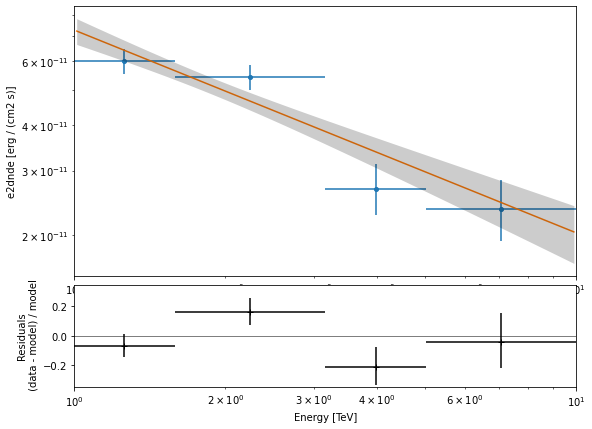

In [27]:
ax_sed, ax_residuals = analysis.flux_points.plot_fit()

The flux points can be exported to a fits table following the format defined [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/flux_points/index.html) 

In [28]:
filename = path / "flux-points.fits"
analysis.flux_points.write(filename, overwrite=True)

To check the fit is correct, we compute the map of the sqrt_ts of the excess counts above the current model.

Computing excess maps.


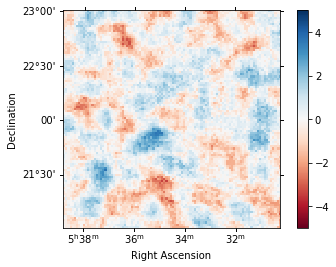

In [29]:
analysis.get_excess_map()
analysis.excess_map["sqrt_ts"].plot(
    add_cbar=True, cmap="RdBu", vmin=-5, vmax=5
);

## What's next

You can look at the same analysis without the high level interface in [analysis_2](analysis_2.ipynb)

You can see how to perform a 1D spectral analysis of the same data in [spectral analysis](../analysis/1D/spectral_analysis.ipynb)